In [1]:
%pylab inline
font = {'size':13, 'family':'serif'}
matplotlib.rc('font', **font)

Populating the interactive namespace from numpy and matplotlib


# Computing the CM 

## Basic approach:

In [2]:
# Random points in a sphere:

r = random.random(1000) 
theta = random.random(1000) * 2 - 1
phi = random.random(1000) * 2 * np.pi

x1 = r**(1/3.0) * sin(arccos(theta)) * sin(phi)
y1 = r**(1/3.0) * sin(arccos(theta)) * cos(phi)
z1 = r**(1/3.0) * theta

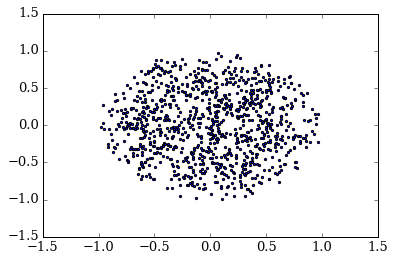

In [3]:
scatter(x1, z1, s=5)

In [4]:
# CM coordinates:
xCM = sum(x1)/len(x1)
yCM = sum(y1)/len(y1)
zCM = sum(z1)/len(z1)

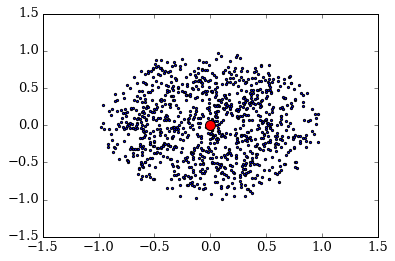

In [5]:
scatter(x1, z1, s=5)
scatter(xCM, zCM, s=100, c='r')

## Iterative approach:


In [211]:
def CM(x, y, z, vx, vy, vz, delta):
    
    N = len(x)
    xCM = sum(x)/len(x)
    yCM = sum(y)/len(y)
    zCM = sum(z)/len(z)

    xCM_new = [xCM]
    yCM_new = [yCM]
    zCM_new = [zCM]
    
    xCM = 0.0
    yCM = 0.0
    zCM = 0.0

    
    vxCM_new = [sum(vx)/N]
    vyCM_new = [sum(vy)/N]
    vzCM_new = [sum(vz)/N]
    R1 = np.sqrt((x - xCM_new)**2 + (y - yCM_new)**2 + (z - zCM_new)**2)
    Rnow = [max(R1)]

    while (np.sqrt((xCM_new[-1]-xCM)**2 + (yCM_new[-1]-yCM)**2 +(zCM_new[-1]-zCM)**2) > delta):
        xCM = xCM_new[-1]
        yCM = yCM_new[-1]
        zCM = zCM_new[-1]
        Rcm = np.sqrt(xCM**2 + yCM**2 + zCM**2)
        R = np.sqrt((x - xCM)**2 + (y - yCM)**2 + (z - zCM)**2)
        Rmax = max(R)
        index = where(R<Rmax/2.0)
        x = x[index]
        y = y[index]
        z = z[index]
        vx = vx[index]
        vy = vy[index]
        vz = vz[index]
        N = len(x)
        xCM_new.append(sum(x)/N)
        yCM_new.append(sum(y)/N)
        zCM_new.append(sum(z)/N)
        vxCM_new.append(sum(vx)/N)
        vyCM_new.append(sum(vy)/N)
        vzCM_new.append(sum(vz)/N)
        Rnow.append(max(np.sqrt((x - xCM_new[-1])**2 + (y - yCM_new[-1])**2 + (z - zCM_new[-1])**2)))

        #scatter(xCM_new, yCM_new)

    print N
    return xCM_new, yCM_new, zCM_new, vxCM_new, vyCM_new, vzCM_new, Rnow

In [95]:
CM(x1, y1, z1, 0, 0, 0, 0.5)


1000


([-0.0055994813038382297],
 [-0.042259406068041232],
 [0.0091327784686695782],
 [0],
 [0],
 [0],
 [])

# Testing the code in a simulation snapshot:

In [8]:
from pygadgetreader import *

In [9]:
positions = readsnap("../../data/LMCMW/MW1LMC4/snapshots/MW1LMC4_000", 'pos', 'dm')
velocities = readsnap("../../data/LMCMW/MW1LMC4/snapshots/MW1LMC4_000", 'vel', 'dm')
particles_ids = readsnap("../../data/LMCMW/MW1LMC4/snapshots/MW1LMC4_000", 'pid', 'dm')
disk = readsnap("../../data/LMCMW/MW1LMC4/snapshots/MW1LMC4_000", 'pos', 'disk')
vdisk = readsnap("../../data/LMCMW/MW1LMC4/snapshots/MW1LMC4_000", 'vel', 'disk')
bulge = readsnap("../../data/LMCMW/MW1LMC4/snapshots/MW1LMC4_000", 'pos', 'bulge')
vbulge = readsnap("../../data/LMCMW/MW1LMC4/snapshots/MW1LMC4_000", 'vel', 'bulge')

#potential = readsnap("../../data/LMCMW/MW1LMC4/snapshots/MW1LMC4_000", 'pot', 'dm')



Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Positions
Returning DISK  Velocities
Returning BULGE Positions
Returning BULGE Velocities


### Finging MW DM particles & LMC DM particles

In [10]:
X = sort(particles_ids)
limit = X[29999]
index_mw = where(particles_ids<=49376)
index_LMC = where(particles_ids>49376)

In [11]:
print X
print limit
print len(X)
print int(len(X)/2.0 - 1.0)

[    1     2     3 ..., 79998 79999 80000]
49376
60000
29999


In [12]:
x_sim_mw = positions[index_mw[0],0]
y_sim_mw = positions[index_mw[0],1]
z_sim_mw = positions[index_mw[0],2]

x_sim_lmc = positions[index_LMC[0],0]
y_sim_lmc = positions[index_LMC[0],1]
z_sim_lmc = positions[index_LMC[0],2]

vx_sim_mw = velocities[index_mw[0],0]
vy_sim_mw = velocities[index_mw[0],1]
vz_sim_mw = velocities[index_mw[0],2]

vx_sim_lmc = velocities[index_LMC[0],0]
vy_sim_lmc = velocities[index_LMC[0],1]
vz_sim_lmc = velocities[index_LMC[0],2]

x_disk = disk[:,0]
y_disk = disk[:,1]
z_disk = disk[:,2]

vx_disk = vdisk[:,0]
vy_disk = vdisk[:,1]
vz_disk = vdisk[:,2]

x_bulge = bulge[:,0]
y_bulge = bulge[:,1]
z_bulge = bulge[:,2]

vx_bulge = vbulge[:,0]
vy_bulge = vbulge[:,1]
vz_bulge = vbulge[:,2]


print len(x_sim_mw), len(x_sim_lmc), len(x_disk), len(x_bulge)

30000 30000 10000 10000


(-20, 20)

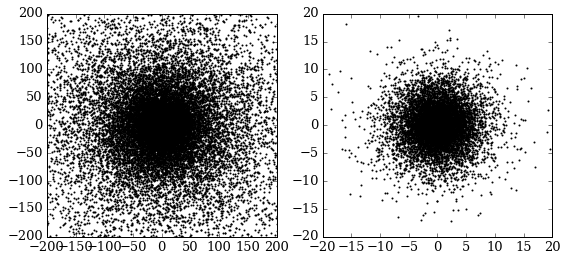

In [13]:
figure(figsize=(14, 4))
subplot(1, 3, 1)
scatter(x_sim_mw, z_sim_mw, s=1.0)
xlim(-200, 200)
ylim(-200, 200)

subplot(1, 3, 2)
scatter(x_disk, y_disk, s=1.0)
xlim(-20, 20)
ylim(-20, 20)

(-200, 200)

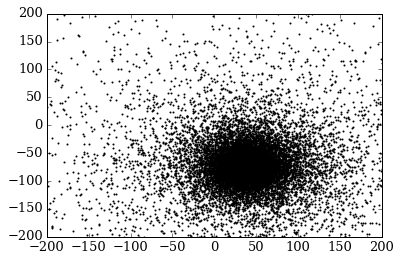

In [14]:
scatter(x_sim_lmc, z_sim_lmc, s=1.0)
xlim(-200, 200)
ylim(-200, 200)

In [117]:
X_sim_mwCM, Y_sim_mwCM, Z_sim_mwCM, vX_sim_mwCM, vY_sim_mwCM, vZ_sim_mwCM = CM(x_sim_mw, y_sim_mw, z_sim_mw, vx_sim_mw, vy_sim_mw, vz_sim_mw, 0.4)
X_sim_lmcCM, Y_sim_lmcCM, Z_sim_lmcCM, vX_sim_lmcCM, vY_sim_lmcCM, vZ_sim_lmcCM  = CM(x_sim_lmc, y_sim_lmc, z_sim_lmc, vx_sim_lmc, vy_sim_lmc, vz_sim_lmc, 0.1)

print X_sim_mwCM[-1], Y_sim_mwCM[-1], Z_sim_mwCM[-1]

7207
7179
-0.134805437164 -0.228039945431 -0.469590179795


In [119]:
X_sim_disk, Y_sim_disk, Z_sim_disk, vX_sim_disk, vY_sim_disk, vZ_sim_disk = CM(x_disk, y_disk, z_disk, vx_disk, vy_disk, vz_disk, 0.01)
X_sim_bulge, Y_sim_bulge, Z_sim_bulge, vX_sim_bulge, vY_sim_bulge, vZ_sim_bulge = CM(x_bulge, y_bulge, z_bulge, vx_bulge, vy_bulge, vz_bulge, 0.01)

print len(X_sim_disk)
print len(X_sim_bulge)
print X_sim_disk[-1], Y_sim_disk[-1], Z_sim_disk[-1]
print X_sim_bulge[-1], Y_sim_bulge[-1], Z_sim_bulge[-1]

9917
9119
2
11
-0.0197111796958 0.0490153971321 0.00252089308577
0.0131956816426 0.0182834612276 0.0418945071545


In [120]:
print vX_sim_mwCM[-1], vY_sim_mwCM[-1], vZ_sim_mwCM[-1]
print vX_sim_disk[-1], vY_sim_disk[-1], vZ_sim_disk[-1]
print vX_sim_bulge[-1], vY_sim_bulge[-1], vZ_sim_bulge[-1]

1.35088539679 -0.140483078653 -3.06713958651
-2.22825624559 -0.472409032076 0.0510102072298
0.806298897734 -0.373559706853 0.225122153308


In [121]:
Rcmmw = np.zeros(len(X_sim_mwCM))
Rlmc = np.zeros(len(X_sim_lmcCM))
Rdisk = np.zeros(len(X_sim_disk))
Rbulge = np.zeros(len(X_sim_bulge))

Vcmmw = np.zeros(len(X_sim_mwCM))
Vlmc = np.zeros(len(X_sim_lmcCM))
Vdisk = np.zeros(len(X_sim_disk))
Vbulge = np.zeros(len(X_sim_bulge))

iterationmw = np.zeros(len(X_sim_mwCM))
iterationlmc = np.zeros(len(X_sim_lmcCM))
iterationdisk = np.zeros(len(X_sim_disk))
iterationbulge = np.zeros(len(X_sim_bulge))


for i in range(len(X_sim_mwCM)):
    Rcmmw[i] = np.sqrt(X_sim_mwCM[i]**2 + Y_sim_mwCM[i]**2 + Z_sim_mwCM[i]**2)
    Vcmmw[i] = np.sqrt(vX_sim_mwCM[i]**2 + vY_sim_mwCM[i]**2 + vZ_sim_mwCM[i]**2)
    iterationmw[i] = float(i)

for i in range(len(X_sim_lmcCM)):
    Rlmc[i] = np.sqrt(X_sim_lmcCM[i]**2 + Y_sim_lmcCM[i]**2 + Z_sim_lmcCM[i]**2)
    Vlmc[i] = np.sqrt(vX_sim_lmcCM[i]**2 + vY_sim_lmcCM[i]**2 + vZ_sim_lmcCM[i]**2)
    iterationlmc[i] = float(i)

for i in range(len(X_sim_disk)):
    Rdisk[i] = np.sqrt(X_sim_disk[i]**2 + Y_sim_disk[i]**2 + Z_sim_disk[i]**2)
    Vdisk[i] = np.sqrt(vX_sim_disk[i]**2 + vY_sim_disk[i]**2 + vZ_sim_disk[i]**2)
    iterationdisk[i] = float(i)
    
for i in range(len(X_sim_bulge)):
    Rbulge[i] = np.sqrt(X_sim_bulge[i]**2 + Y_sim_bulge[i]**2 + Z_sim_bulge[i]**2)
    Vbulge[i] = np.sqrt(vX_sim_bulge[i]**2 + vY_sim_bulge[i]**2 + vZ_sim_bulge[i]**2)
    iterationbulge[i] = float(i)

In [122]:
def difference(R):
    Rdif = np.zeros(len(R)-1)
    for i in range(len(R)-1):
        Rdif[i] = abs(R[i+1] - R[i])
    return Rdif

In [123]:
RdifMW = difference(Rcmmw)
Rdiflmc = difference(Rlmc)

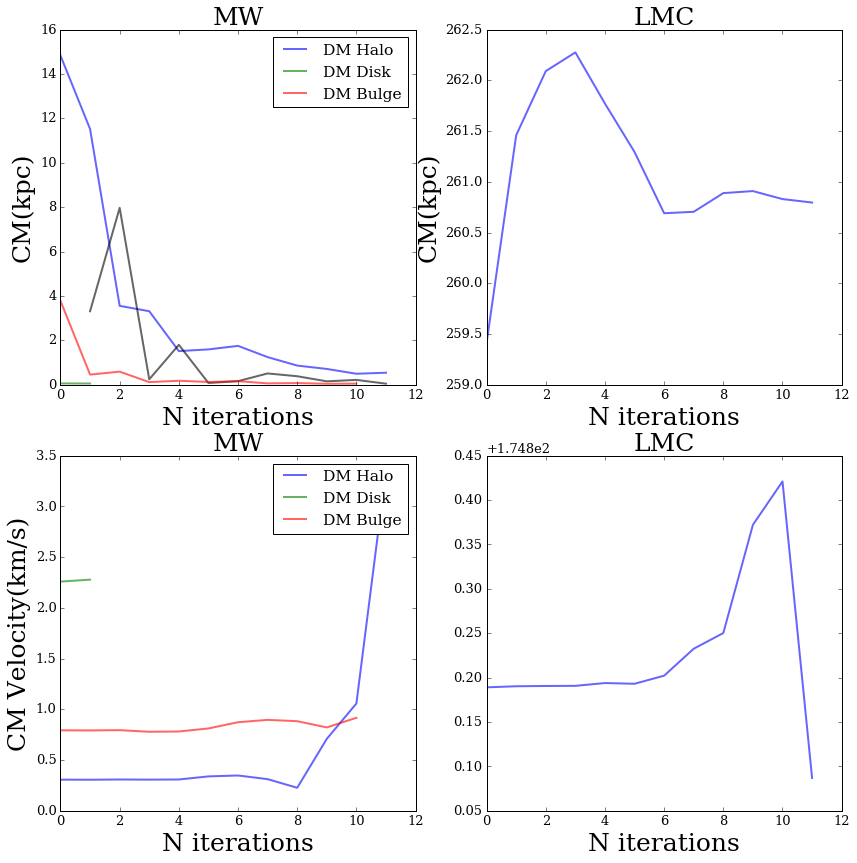

In [124]:
figure(figsize=(14, 14))

subplot(2, 2, 1)
plot(iterationmw, Rcmmw, lw=2, alpha=0.6, label='DM Halo')
plot(iterationmw[1:], RdifMW, lw=2, c='k', alpha=0.6)
plot(iterationdisk, Rdisk, lw=2, alpha=0.6, label='DM Disk')
plot(iterationbulge, Rbulge, lw=2, alpha=0.6, label='DM Bulge')
xlabel('N iterations', fontsize=25)
ylabel('CM(kpc)', fontsize=25)
title('MW', fontsize=25)
legend()

subplot(2, 2, 2)
plot(iterationlmc, Rlmc, lw=2, alpha=0.6)
#plot(iterationlmc[1:], Rdiflmc, lw=2, c='k', alpha=0.6)
xlabel('N iterations', fontsize=25)
ylabel('CM(kpc)', fontsize=25)
title('LMC', fontsize=25)

subplot(2, 2, 3)
plot(iterationmw, Vcmmw, lw=2, alpha=0.6, label='DM Halo')
#plot(iterationmw[1:], VdifMW, lw=2, c='k', alpha=0.6)
plot(iterationdisk, Vdisk, lw=2, alpha=0.6, label='DM Disk')
plot(iterationbulge, Vbulge, lw=2, alpha=0.6, label='DM Bulge')
xlabel('N iterations', fontsize=25)
ylabel('CM Velocity(km/s)', fontsize=25)
title('MW', fontsize=25)
legend()

subplot(2, 2, 4)
plot(iterationlmc, Vlmc, lw=2, alpha=0.6)
#plot(iterationlmc[1:], Vlmc, lw=2, c='k', alpha=0.6)
xlabel('N iterations', fontsize=25)
title('LMC', fontsize=25)


savefig('CM_computation_convergence.png', bbox_inches='tight')


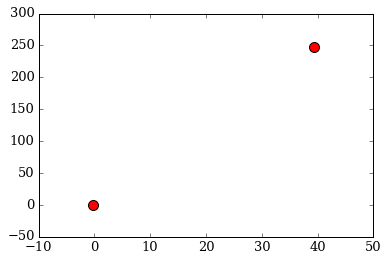

In [22]:
scatter(X_sim_mwCM[-1], Y_sim_mwCM[-1], c='r', s=100)
scatter(X_sim_lmcCM[-1], Y_sim_lmcCM[-1], c='r', s=100)

# Comparing the same snapshot with different resolution, Comparisson with the potential method

In [23]:
potbulge = readsnap("../../data/LMCMW/MW1LMC4/a1/MW1LMC4_a1H6HR_000", 'pot', 'bulge')
posbulge = readsnap("../../data/LMCMW/MW1LMC4/a1/MW1LMC4_a1H6HR_000", 'pos', 'bulge')
velbulge = readsnap("../../data/LMCMW/MW1LMC4/a1/MW1LMC4_a1H6HR_000", 'vel', 'bulge')

pothalos = readsnap("../../data/LMCMW/MW1LMC4/a1/MW1LMC4_a1H6HR_000", 'pot', 'dm')
poshalos = readsnap("../../data/LMCMW/MW1LMC4/a1/MW1LMC4_a1H6HR_000", 'pos', 'dm')
velhalos = readsnap("../../data/LMCMW/MW1LMC4/a1/MW1LMC4_a1H6HR_000", 'vel', 'dm')
idhalos = readsnap("../../data/LMCMW/MW1LMC4/a1/MW1LMC4_a1H6HR_000", 'pid', 'dm')


potdisk = readsnap("../../data/LMCMW/MW1LMC4/a1/MW1LMC4_a1H6HR_000", 'pot', 'disk')
posdisk = readsnap("../../data/LMCMW/MW1LMC4/a1/MW1LMC4_a1H6HR_000", 'pos', 'disk')
veldisk = readsnap("../../data/LMCMW/MW1LMC4/a1/MW1LMC4_a1H6HR_000", 'vel', 'disk')


Returning BULGE Potential
Returning BULGE Positions
Returning BULGE Velocities
Returning DM    Potential
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities


In [33]:
potbulgeLR = readsnap("../../data/LMCMW/MW1LMC4/a1/MW1LMC4a1H6_000", 'pot', 'bulge')
posbulgeLR = readsnap("../../data/LMCMW/MW1LMC4/a1/MW1LMC4a1H6_000", 'pos', 'bulge')
velbulgeLR = readsnap("../../data/LMCMW/MW1LMC4/a1/MW1LMC4a1H6_000", 'vel', 'bulge')

pothalosLR = readsnap("../../data/LMCMW/MW1LMC4/a1/MW1LMC4a1H6_000", 'pot', 'dm')
poshalosLR = readsnap("../../data/LMCMW/MW1LMC4/a1/MW1LMC4a1H6_000", 'pos', 'dm')
velhalosLR = readsnap("../../data/LMCMW/MW1LMC4/a1/MW1LMC4a1H6_000", 'vel', 'dm')
idhalosLR = readsnap("../../data/LMCMW/MW1LMC4/a1/MW1LMC4a1H6_000", 'pid', 'dm')


potdiskLR = readsnap("../../data/LMCMW/MW1LMC4/a1/MW1LMC4a1H6_000", 'pot', 'disk')
posdiskLR = readsnap("../../data/LMCMW/MW1LMC4/a1/MW1LMC4a1H6_000", 'pos', 'disk')
veldiskLR = readsnap("../../data/LMCMW/MW1LMC4/a1/MW1LMC4a1H6_000", 'vel', 'disk')

Returning BULGE Potential
Returning BULGE Positions
Returning BULGE Velocities
Returning DM    Potential
Returning DM    Positions
Returning DM    Velocities
Returning DM    Particle IDs
Returning DISK  Potential
Returning DISK  Positions
Returning DISK  Velocities


In [60]:
# -------------------- High res -----------------

CMBpot = where(potbulge == min(potbulge))
XCMbulge, YCMbulge, ZCMbulge = posbulge[CMBpot, 0], posbulge[CMBpot, 1], posbulge[CMBpot, 2]

Xbulge, Ybulge, Zbulge = posbulge[:, 0], posbulge[:, 1], posbulge[:, 2]
vXbulge, vYbulge, vZbulge = velbulge[:, 0], velbulge[:, 1], velbulge[:, 2]

CMDpot = where(potdisk == min(potdisk))
XCMdisk, YCMdisk, ZCMdisk = posdisk[CMDpot, 0], posdisk[CMDpot, 1], posdisk[CMDpot, 2]

Xdisk, Ydisk, Zdisk = posdisk[:, 0], posdisk[:, 1], posdisk[:, 2]
vXdisk, vYdisk, vZdisk = veldisk[:, 0], veldisk[:, 1], veldisk[:, 2]

Xhalo, Yhalo, Zhalo = poshalos[:, 0], poshalos[:, 1], poshalos[:, 2]
vXhalo, vYhalo, vZhalo = velhalos[:, 0], velhalos[:, 1], velhalos[:, 2]

# -------------------- Low res -----------------

CMpotLR = where(potbulgeLR == min(potbulgeLR))
XCMbulgeLR, YCMbulgeLR, ZCMbulgeLR = posbulgeLR[CMpotLR, 0], posbulgeLR[CMpotLR, 1], posbulgeLR[CMpotLR, 2]

XbulgeLR, YbulgeLR, ZbulgeLR = posbulgeLR[:, 0], posbulgeLR[:, 1], posbulgeLR[:, 2]
vXbulgeLR, vYbulgeLR, vZbulgeLR = velbulgeLR[:, 0], velbulgeLR[:, 1], velbulgeLR[:, 2]

CMDpotLR = where(potdiskLR == min(potdiskLR))
XCMdiskLR, YCMdiskLR, ZCMdiskLR = posdisk[CMDpotLR, 0], posdisk[CMDpotLR, 1], posdisk[CMDpotLR, 2]

XdiskLR, YdiskLR, ZdiskLR = posdiskLR[:, 0], posdiskLR[:, 1], posdiskLR[:, 2]
vXdiskLR, vYdiskLR, vZdiskLR = veldiskLR[:, 0], veldiskLR[:, 1], veldiskLR[:, 2]

XhaloLR, YhaloLR, ZhaloLR = poshalosLR[:, 0], poshalosLR[:, 1], poshalosLR[:, 2]
vXhaloLR, vYhaloLR, vZhaloLR = velhalosLR[:, 0], velhalosLR[:, 1], velhalosLR[:, 2]

print XCMbulge, YCMbulge, ZCMbulge 
print XCMbulgeLR, YCMbulgeLR, ZCMbulgeLR 

[[-1.61738527]] [[-5.86820316]] [[-4.73749733]]
[[ 7.1663065]] [[ 6.00355339]] [[-4.12696266]]


## Bulge CM

In [126]:
xbulge, ybulge,zbulge, vxbulge, vybulge, vzbulge = CM(Xbulge, Ybulge, Zbulge, vXbulge, vYbulge, vZbulge, 0.01)
xbulgeLR, ybulgeLR, zbulgeLR, vxbulgeLR, vybulgeLR, vzbulgeLR = CM(XbulgeLR, YbulgeLR, ZbulgeLR, vXbulgeLR, vYbulgeLR, vZbulgeLR, 0.1)


2150
9928


In [41]:
#High Res
print xbulge[-1] - XCMbulge
print ybulge[-1] - YCMbulge
print zbulge[-1] - ZCMbulge
# Low res
print xbulgeLR[-1] - XCMbulgeLR
print ybulgeLR[-1] - YCMbulgeLR
print zbulgeLR[-1] - ZCMbulgeLR

[[-0.02869833]]
[[ 0.02588797]]
[[-0.00693893]]
[[-0.03883457]]
[[-0.06575966]]
[[-0.03263283]]


## Disk CM

In [273]:
xdisk, ydisk, zdisk, vxdisk, vydisk, vzdisk, Rdisk = CM(Xdisk, Ydisk, Zdisk, vXdisk, vYdisk, vZdisk, 0.01)
xdiskLR, ydiskLR, zdiskLR, vxdiskLR, vydiskLR, vzdiskLR, RdiskLR = CM(XdiskLR, YdiskLR, ZdiskLR, vXdiskLR, vYdiskLR, vZdiskLR, 0.1)


4400
7039


In [274]:
CMdisk_pot = np.where(potdisk == min(potdisk))
xCMDpot, yCMDpot, zCMDpot = Xdisk[CMdisk_pot], Ydisk[CMdisk_pot], Zdisk[CMdisk_pot]
RCMDpot = np.sqrt(xCMDpot**2 + yCMDpot**2 + zCMDpot**2)


CMdisk_potLR = np.where(potdiskLR == min(potdiskLR))
xCMDpotLR, yCMDpotLR, zCMDpotLR = XdiskLR[CMdisk_potLR], YdiskLR[CMdisk_potLR], ZdiskLR[CMdisk_potLR]
RCMDpotLR = np.sqrt(xCMDpotLR**2 + yCMDpotLR**2 + zCMDpotLR**2)

In [275]:
Rcm_disk = np.zeros(len(xdisk))
Rcm_diskLR = np.zeros(len(xdiskLR))

Vcm_disk = np.zeros(len(xdisk))
Vcm_diskLR = np.zeros(len(xdiskLR))

RDisk = np.zeros(len(xdisk))
RDiskLR = np.zeros(len(xdiskLR))

for i in range(len(xdisk)):
    Rcm_disk[i] = np.sqrt(xdisk[i]**2 + ydisk[i]**2 + zdisk[i]**2)
    Vcm_disk[i] = np.sqrt(vxdisk[i]**2 + vydisk[i]**2 + vzdisk[i]**2)
    RDisk[i] = Rdisk[i]
    
for i in range(len(xdiskLR)):
    Rcm_diskLR[i] = np.sqrt(xdiskLR[i]**2 + ydiskLR[i]**2 + zdiskLR[i]**2)
    Vcm_diskLR[i] = np.sqrt(vxdiskLR[i]**2 + vydiskLR[i]**2 + vzdiskLR[i]**2)
    RDiskLR[i] = RdiskLR[i]


## Halo CM

In [85]:
def LMCMWparticles(ids, NMW, x, y, z, vx, vy, vz, pot):
    X = sort(ids)
    limit = X[NMW]
    index_MW = where(ids<=limit)[0]
    index_LMC = where(ids>limit)[0]
    xmw, ymw, zmw = x[index_MW], y[index_MW], z[index_MW]
    vxmw, vymw, vzmw = vx[index_MW], vy[index_MW], vz[index_MW]
    xlmc, ylmc, zlmc = x[index_LMC], y[index_LMC], z[index_LMC]
    vxlmc, vylmc, vzlmc = vx[index_LMC], vy[index_LMC], vz[index_LMC]
    potmw = pot[index_MW]
    potlmc = pot[index_LMC]
    return xmw, ymw, zmw, vxmw, vymw, vzmw, xlmc, ylmc, zlmc, vxlmc, vylmc, vzlmc, potmw, potlmc


In [71]:
Xmwhalo, Ymwhalo, Zmwhalo, vXmwhalo, vYmwhalo, vZmwhalo, Xlmchalo,\
Ylmchalo, Zlmchalo, vXlmchalo, vYlmchalo, vZlmchalo, potMWhalo, potLMChalo\
= LMCMWparticles(idhalos, 299999, Xhalo, Yhalo, Zhalo, vXhalo, vYhalo, vZhalo, pothalos)


In [186]:
XmwhaloLR, YmwhaloLR, ZmwhaloLR, vXmwhaloLR, vYmwhaloLR, vZmwhaloLR, XlmchaloLR,\
YlmchaloLR, ZlmchaloLR, vXlmchaloLR, vYlmchaloLR, vZlmchaloLR, potMWhaloLR, potLMChaloLR\
= LMCMWparticles(idhalosLR, 29999, XhaloLR, YhaloLR, ZhaloLR, vXhaloLR, vYhaloLR, vZhaloLR, pothalosLR)


### Computing halo CM with positions

In [247]:
xmwhalo, ymwhalo, zmwhalo, vxmwhalo, vymwhalo, vzmwhalo, Rmwhalo = CM(Xmwhalo, Ymwhalo, Zmwhalo, vXmwhalo, vYmwhalo, vZmwhalo, 0.03)
xlmchalo, ylmchalo, zlmchalo, vxlmchalo, vylmchalo, vzlmchalo, Rlmchalo = CM(Xlmchalo, Ylmchalo, Zlmchalo, vXlmchalo, vYlmchalo, vZlmchalo, 0.1)


xmwhaloLR, ymwhaloLR, zmwhaloLR, vxmwhaloLR, vymwhaloLR, vzmwhaloLR, RmwhaloLR = CM(XmwhaloLR, YmwhaloLR, ZmwhaloLR, vXmwhaloLR, vYmwhaloLR, vZmwhaloLR, 0.3)
xlmchaloLR, ylmchaloLR, zlmchaloLR, vxlmchaloLR, vylmchaloLR, vzlmchaloLR, RlmchaloLR = CM(XlmchaloLR, YlmchaloLR, ZlmchaloLR, vXlmchaloLR, vYlmchaloLR, vZlmchaloLR, 0.1)


854
7179
116
7179


### Computing halo CM with the potential

In [248]:
CMHmwpot = where(potMWhalo == min(potMWhalo))
XCMHmw, YCMHmw, ZCMHmw = Xmwhalo[CMHmwpot], Ymwhalo[CMHmwpot], Zmwhalo[CMHmwpot]
vXCMHmw, vYCMHmw, vZCMHmw = vXmwhalo[CMHmwpot], vYmwhalo[CMHmwpot], vZmwhalo[CMHmwpot]

RCMHmw = np.sqrt(XCMHmw**2 + YCMHmw**2 + ZCMHmw**2)
VCMHmw = np.sqrt(vXCMHmw**2 + vYCMHmw**2 + vZCMHmw**2)


CMHmwpotLR = where(potMWhaloLR == min(potMWhaloLR))
XCMHmwLR, YCMHmwLR, ZCMHmwLR = XmwhaloLR[CMHmwpotLR], YmwhaloLR[CMHmwpotLR], ZmwhaloLR[CMHmwpotLR]
vXCMHmwLR, vYCMHmwLR, vZCMHmwLR = vXmwhaloLR[CMHmwpotLR], vYmwhaloLR[CMHmwpotLR], vZmwhaloLR[CMHmwpotLR]

RCMHmwLR = np.sqrt(XCMHmwLR**2 + YCMHmwLR**2 + ZCMHmwLR**2)
VCMHmwLR = np.sqrt(vXCMHmw**2 + vYCMHmw**2 + vZCMHmw**2)

In [249]:
Rcm_mwhalo = np.zeros(len(xmwhalo))
Rcm_lmchalo = np.zeros(len(xlmchalo))
RmwHalo = np.zeros(len(Rmwhalo))
RmwHaloLR = np.zeros(len(RmwhaloLR))


Vcm_mwhalo = np.zeros(len(xmwhalo))
Vcm_lmchalo = np.zeros(len(xlmchalo))

Rcm_mwhaloLR = np.zeros(len(xmwhaloLR))
Rcm_lmchaloLR = np.zeros(len(xlmchaloLR))

Vcm_mwhaloLR = np.zeros(len(xmwhaloLR))
Vcm_lmchaloLR = np.zeros(len(xlmchaloLR))



for i in range(len(xmwhalo)):
    Rcm_mwhalo[i] = np.sqrt(xmwhalo[i]**2 + ymwhalo[i]**2 + zmwhalo[i]**2)
    Vcm_mwhalo[i] = np.sqrt(vxmwhalo[i]**2 + vymwhalo[i]**2 + vzmwhalo[i]**2)
    Rcm_mwhaloLR[i] = np.sqrt(xmwhaloLR[i]**2 + ymwhaloLR[i]**2 + zmwhaloLR[i]**2)
    Vcm_mwhaloLR[i] = np.sqrt(vxmwhaloLR[i]**2 + vymwhaloLR[i]**2 + vzmwhaloLR[i]**2)
    RmwHalo[i] = Rmwhalo[i]
    RmwHaloLR[i] = RmwhaloLR[i]



for i in range(len(xlmchalo)):
    Rcm_lmchalo[i] = np.sqrt(xlmchalo[i]**2 + ylmchalo[i]**2 + zlmchalo[i]**2)
    Vcm_lmchalo[i] = np.sqrt(vxlmchalo[i]**2 + vylmchalo[i]**2 + vzlmchalo[i]**2)


In [250]:
print len(RmwHalo)
print len(Rcm_mwhalo)
print len(xmwhalo)

16
16
16


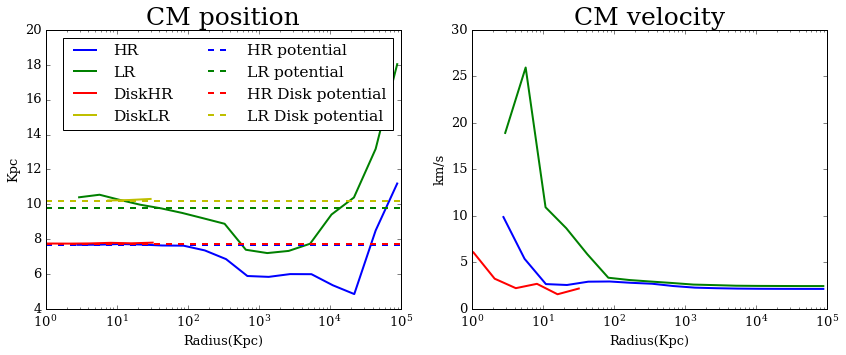

In [295]:
figure(figsize=(14, 5))
subplot(1, 2, 1)
title('CM position', fontsize=25)
plot(Rmwhalo, Rcm_mwhalo, lw=2, label='HR')
plot(RmwhaloLR, Rcm_mwhaloLR, lw=2, label='LR')
plot(RDisk, Rcm_disk, lw=2, label='DiskHR')
plot(RDiskLR, Rcm_diskLR, lw=2, label='DiskLR', c='y')

xscale('log')
axhline(RCMHmw, lw=2, ls='--', label='HR potential')
axhline(RCMHmwLR, lw=2, ls='--', c='g', label='LR potential')
axhline(RCMDpot, lw=2, ls='--', c='r', label='HR Disk potential')
axhline(RCMDpotLR, lw=2, ls='--', c='y', label='LR Disk potential')

xlabel('Radius(Kpc)')
ylabel('Kpc')
legend(loc='best',ncol=2 )

subplot(1, 2, 2)
title('CM velocity', fontsize=25)
plot(Rmwhalo, Vcm_mwhalo, lw=2)
plot(RmwhaloLR, Vcm_mwhaloLR, lw=2)
plot(RDisk, Vcm_disk, lw=2, label='Disk')
#axhline(VCMHmw, lw=2, ls='--', label='HR potential')
#axhline(VCMHmwLR, lw=2, ls='--', c='g', label='LR potential')
xlabel('Radius(Kpc)')
ylabel('km/s')
xscale('log')

#axhline(RCMHmw, lw=2, alpha=0.6, c='k')
#axhline(RCMHmwLR, lw=2, alpha=0.6, c='k')
savefig('CM_comparison.png', bbox_inches='tight')

(128500, 130000)

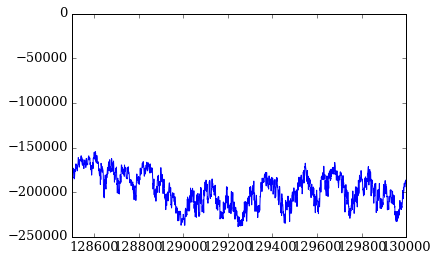

In [289]:
plot(potMWhalo)
xlim(128500, 130000)



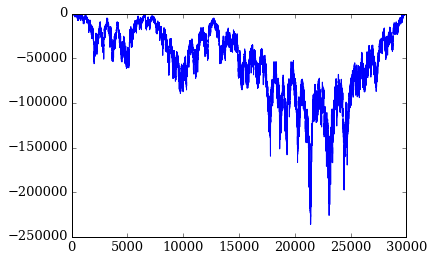

In [256]:
plot(potMWhaloLR)


In [280]:
## Poisson Noise

In [353]:
def poissonN(x, y, z):
    R = np.sqrt(x**2 + y**2 + z**2)
    pn = np.zeros(1000)
    pn[0] = np.std(R)/ np.sqrt(len(R))
    Rmax = np.zeros(1000)
    Rmax[0] = max(R)
    i=0
    while len(R)>100:
        i+=1
        low_s = np.where(R <= 0.8*max(R))[0]
        R = R[low_s]
        x, y, z = x[low_s], yl[low_s], z[low_s]
        Rmax[i] = max(R)
        pn[i] = np.std(R) / (len(R)**(3.0/2.0))
        
    index = np.where(pn!=0)[0]
    pn = pn[index]
    min_pn = np.where(pn == min(pn))
    return 
    return pn[index], Rmax[index]


In [354]:
PN, Renclosed = poissonN(Xmwhalo, Ymwhalo, Zmwhalo)

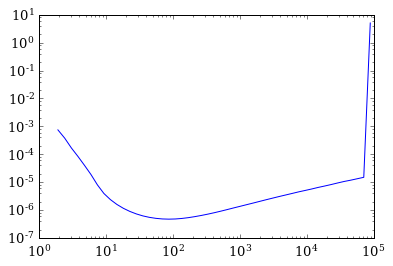

In [357]:
plot(Renclosed, PN)
xscale('log')
yscale('log')